In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time

from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

# our modules
from plotSeries import *
from checkStationarity import *
from GoogleTrendsData import *
from makeDataQuarterly import *
from makeSeriesStationary import *
from predictorsSelection import *
from dataPreProcessing import *
from tsModels import *
from rollingPredictionfuns import *
from fittedAndPredictedValuefuns import *
from bootstrapfuns import *

C:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# 1. Read data (StatCan)

In [2]:
# Read GDP data
warnings.filterwarnings("ignore")
gdp_path = '../../data/expenditure/expenditure_gdp.csv'
gdp = pd.read_csv(gdp_path)
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])

# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})
gdpts.index = gdpts['Date']
gdpts = gdpts.drop(columns = ['Date'])

# create copy of original data to use later
gdp_original = gdpts.copy()

# calculate and add growth rate to the dataframe
gdpts['GDP_GrowthRate'] = gdpts['GDP'].pct_change()
gdpts = gdpts.dropna()

# check sttaionarity of time series
#check_stationarity(gdpts[['GDP_GrowthRate']])

# 2. Get Google Trends data

#### API call to get predictors data for GDP 

In [31]:
# get caegories and keywords from csv file for GDP
key_path = '../../data/keywords_data/GDP.csv'
key_data = pd.read_csv(key_path)
cat_lst = key_data['CatNo'].unique()                    # list of categories
keywords_lst = key_data['Keywords'].dropna()            # list of selected keywords
keyCat_lst = key_data['keywordCatNo'].astype('Int64').dropna()   # list of categories corresponding to keywords


###################################################################################################
# get dataframe of timeseries for categories (GDP)

cat_queries_dict = {}
cat_topics_dict = {}

# get time series and related queries and topics of categories
for i, category in enumerate(cat_lst):
    category = str(category)
    data, queries, topics = get_trends_gdp(category=category, related_queries=2, related_topics=2)
    cat_queries_dict[category] = queries
    cat_topics_dict[category] = topics

    # Code to append data for different columns in data frame
    if i == 0:
        data.rename(columns={'': category}, inplace=True)
        categoryts = data.drop(columns=['isPartial'])
    else:
        data.rename(columns={'': category}, inplace=True)
        data = data.drop(columns=['isPartial'])
        categoryts = categoryts.join(data)

In [34]:
# write data to csv
categoryts.to_csv('gdp_category_ts.csv')

In [3]:
# Read data from csv
categoryts = pd.read_csv('gdp_category_ts.csv', index_col=0)

# 3. Make data stationary

In [20]:
# GDP

# select predictors and make them stationary
less_predictors = select_variables_with_correlation(gdpts, categoryts)
temp_cat = get_gdp_data_quarterly(less_predictors, match='0')
tempcat = remove_seasonality(detrend(normalize(temp_cat)))

# response
response = gdpts[['GDP_GrowthRate']]

# Make predictors dataframe in right form
predictor = make_predictors_df(tempcat)

# 4. Model fit

### GDP

In [21]:
# Apply DFM
factors = apply_dfm(predictor, num_factors=20, order_factors=1)

# split train, test and extra test set (use 13 factors as predictors)
train, test, extra_test = ts_train_test_split(response, factors.iloc[:, 0:13], test_size=0.2)

modelfit = fit_arima_model(train)
pred_gdpGrowth = rolling_prediction(train, test, extra_test)
pred_error, fig, fitted_predicted_data = fitted_and_predicted_gdp(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test)
pred_error

60524.892990697874

In [ ]:
# Bootstrap for GDP

# create bootstrap samples
bs_samples = get_bootstrap_samples(train, n_sample=10, block_size=9, rs=None)  # rs = RandomState(1234)

# get predicted growth rate uisng bootstrap samples
predicted_growth_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction(df, test, extra_test, dependent_var='GDP_GrowthRate')
    predicted_growth_df.iloc[:, i] = predicted_growth_temp[0]

# get predicted gdp value for bootstrap samples
predicted_gdp_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df[[i]].rename(columns={i: 0})
    _, _, gdp_data = fitted_and_predicted_gdp(modelfit, predicted_growth_rate_temp, gdp_original, train, test, extra_test)
    predicted_gdp_df_bs.iloc[:, i] = gdp_data['Predicted GDP'].dropna()

In [23]:
fig1, pred_growth_data = growth_rate_plot_and_data_bs(predicted_growth_df=predicted_growth_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= modelfit, 
                              gdpts = gdpts, 
                              train = train,
                              pred_gdpGrowth = pred_gdpGrowth)

fig2, pred_gdp_data = gdp_plot_and_data_bs(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test, predicted_gdp_df_bs,
                                          lower_q = 0.025, upper_q = 0.975)

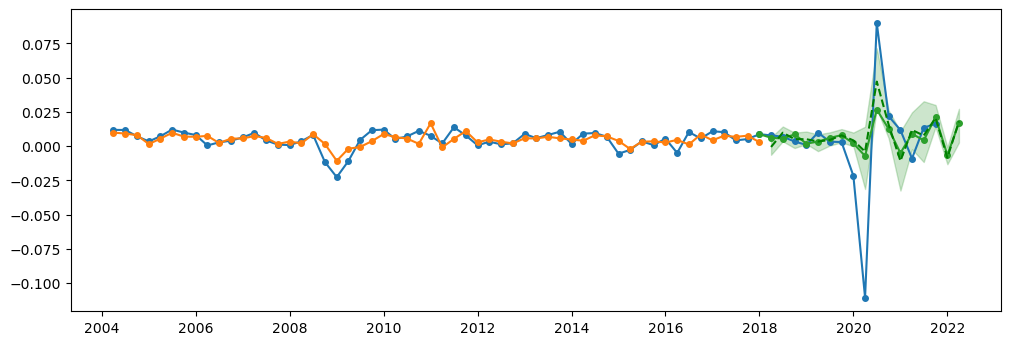

In [33]:
fig1

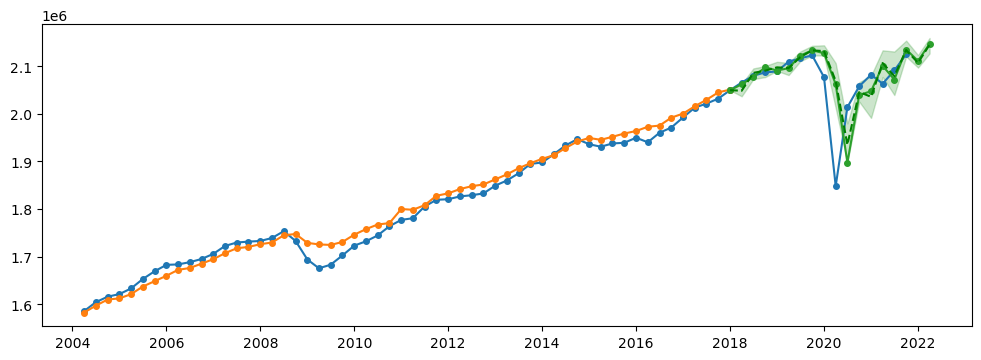

In [34]:
fig2